In [85]:
import os
import sys
import itk
import datetime
import numpy as np
import SimpleITK as sitk
from matplotlib import pyplot as plt

from ormir_xct.util.hildebrand_thickness import (
    compute_local_thickness_from_mask,
    calc_structure_thickness_statistics
)


# Define a global variable for erosion and dilation
# These values are taken directly from the JSW IPL scripts
MISC2 = 27
CALC = MISC2 + 8

# Set the image path
filename = 'J0010803_JOINT.nii'
image_dir = os.path.dirname(os.getcwd())
image_dir = os.path.join(image_dir, 'tests')
image_dir = os.path.join(image_dir, 'data')
seg_path = os.path.join(image_dir, filename)

# Read the image using SimpleITK
seg_image = sitk.ReadImage(seg_path)

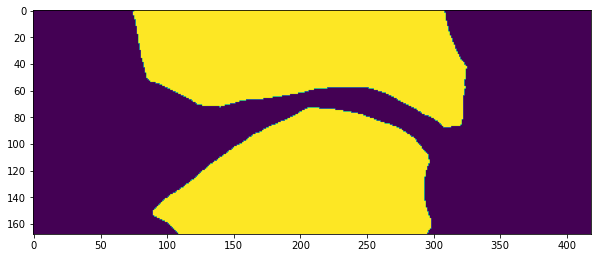

In [86]:
view_slice = (slice(None), seg_image_np.shape[1]//2, slice(None))

fig = plt.figure(figsize=(10,10))

plt.imshow(sitk.GetArrayFromImage(seg_image)[view_slice])

plt.show()

In [87]:
# Image padding only in the X and Y direction
pad_image = sitk.ConstantPad(seg_image, [MISC2, MISC2, 0], [MISC2, MISC2, 0], 0)

# Use a binary threshold filter to set the segmentation image's value to 60 instead of the default 127
# We will use the difference in binary image values when thresholding out the joint space in later steps
pad_image = sitk.BinaryThreshold(pad_image, 1, 127, 60, 0)

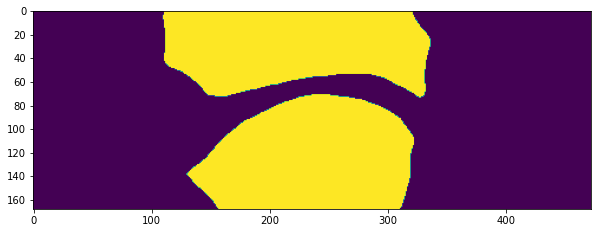

In [88]:
view_slice = (slice(None), seg_image_np.shape[1]//2, slice(None))

fig = plt.figure(figsize=(10,10))

plt.imshow(sitk.GetArrayFromImage(pad_image)[view_slice])

plt.show()

In [89]:
# Binary image dilation using a sphere structural element
dilated_image = sitk.BinaryDilate(pad_image, [MISC2, MISC2, MISC2], sitk.sitkBall, 0, 60)

# Run connected components, sort the components by size, then take only the largest component
connected_image = sitk.ConnectedComponent(dilated_image, True)

# Sort the components by size
relabel_image = sitk.RelabelComponent(connected_image)

# Take only the largest component, set it's value to 127
first_component = sitk.BinaryThreshold(relabel_image, 1, 1, 127, 0)
filled_holes = sitk.BinaryFillhole(first_component, True, 127)

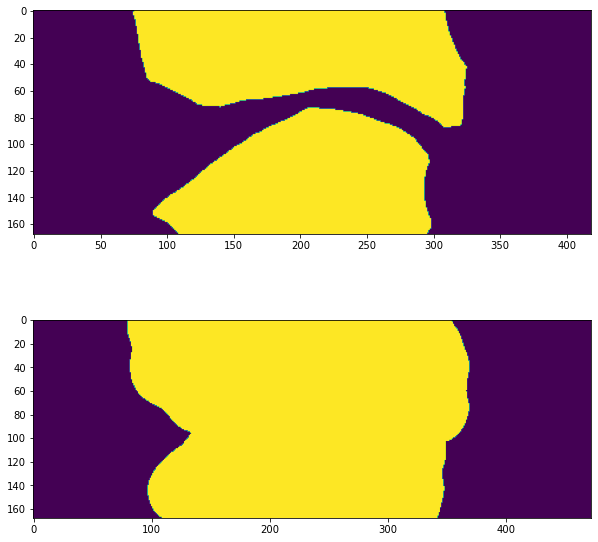

In [90]:
fig, axs = plt.subplots(2, 1, figsize=(10,10))

axs[0].imshow(sitk.GetArrayFromImage(seg_image)[view_slice])
axs[1].imshow(sitk.GetArrayFromImage(filled_holes)[view_slice])

plt.show()

In [95]:
# Erode the image, set the eroded mask's value to 30
eroded_image = sitk.BinaryErode(filled_holes, [CALC, CALC, CALC], sitk.sitkBall, 0, 127)
eroded_image = sitk.BinaryThreshold(eroded_image, 127, 127, 30, 0)

# Add the eroded image (value = 30) and joint image (value = 60) together. 
# Then threshold out JS image (value = 30)
add_image = sitk.Add(eroded_image, pad_image)
add_image = sitk.BinaryThreshold(add_image, 30, 30, 127, 0)

connected_image = sitk.ConnectedComponent(add_image, False)
relabel_image = sitk.RelabelComponent(connected_image)
js_mask = sitk.BinaryThreshold(relabel_image, 1, 1, 1, 0)
dilated_js_mask = sitk.BinaryDilate(js_mask, [CALC, CALC, CALC], sitk.sitkBall, 0, 1)

dilated_js_mask = sitk.Add(dilated_js_mask, pad_image)
dilated_js_mask = sitk.BinaryThreshold(dilated_js_mask, 1, 1, 1, 0)


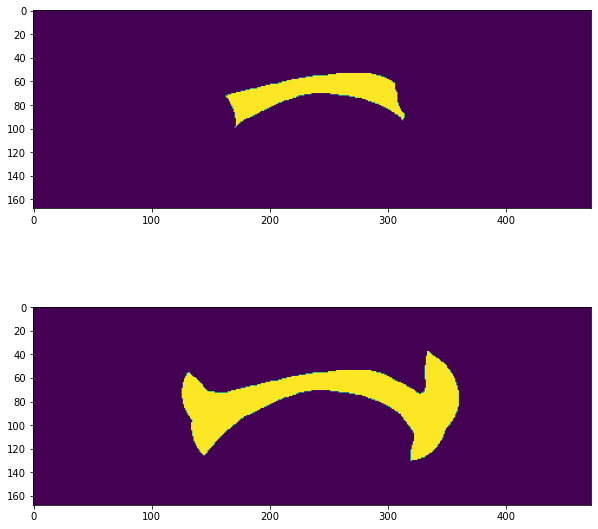

In [96]:
fig, axs = plt.subplots(2, 1, figsize=(10,10))

axs[0].imshow(sitk.GetArrayFromImage(js_mask)[view_slice])
axs[1].imshow(sitk.GetArrayFromImage(dilated_js_mask)[view_slice])

plt.show()

In [97]:
local_thickness = compute_local_thickness_from_mask(
    sitk.GetArrayFromImage(dilated_js_mask),
    0.0607
)

In [98]:
local_thickness_masked = local_thickness * (sitk.GetArrayFromImage(js_mask) != 0)

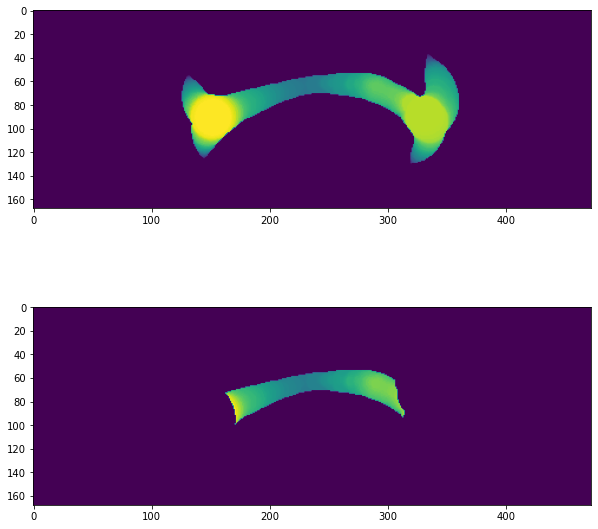

In [99]:
fig, axs = plt.subplots(2, 1, figsize=(10,10))

axs[0].imshow(local_thickness[view_slice])
axs[1].imshow(local_thickness_masked[view_slice])

plt.show()

In [100]:
lts = local_thickness_masked[local_thickness_masked>0]

In [101]:
print(f"JSW.mean : {lts.mean():0.3f} mm")
print(f"JSW.std  : {lts.std():0.3f} mm")
print(f"JSW.min  : {lts.min():0.3f} mm")
print(f"JSW.max  : {lts.max():0.3f} mm")

JSW.mean : 1.558 mm
JSW.std  : 0.397 mm
JSW.min  : 0.738 mm
JSW.max  : 2.500 mm
